# H&M Recommendation System Model Evaluation

This notebook evaluates the trained recommendation models using the comprehensive evaluation framework.

## Evaluation Approaches

1. **Model Loading** - Load pre-trained models
2. **Performance Metrics** - Evaluate recommendation quality
3. **Comparative Analysis** - Compare different model approaches
4. **Business Impact Assessment** - Evaluate practical utility

## Models to Evaluate

- Collaborative Filtering (SVD-based)
- Content-Based Filtering (TF-IDF similarity)
- Purchase Prediction (Classification models)
- Hybrid Recommender (Combined approach)


In [1]:
import sys
import os
sys.path.append('../')

import polars as pl
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import H&M data modelling modules
from hnm_data_analysis.data_modelling import ModelEvaluator

# Set display options
pl.Config.set_tbl_rows(10)
pl.Config.set_tbl_cols(15)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 10)

print("Libraries imported successfully")
print(f"Current working directory: {os.getcwd()}")

Libraries imported successfully
Current working directory: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/notebooks


## Load Test Data

Load the test dataset for evaluation.


In [2]:
# Load test data
print("Loading test dataset...")

test_df = pl.read_parquet("../data/modelling_data/test_data.parquet")
test_pd = test_df.to_pandas()

print(f"Test data shape: {test_df.shape}")
print(f"Test customers: {test_df['customer_id'].n_unique():,}")
print(f"Test articles: {test_df['article_id'].n_unique():,}")

# Sample for faster evaluation if needed
USE_SAMPLE = True
SAMPLE_SIZE = 10000

if USE_SAMPLE and len(test_pd) > SAMPLE_SIZE:
    print(f"\nSampling {SAMPLE_SIZE:,} test transactions for evaluation...")
    test_pd = test_pd.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
    print(f"Sampled test data shape: {test_pd.shape}")

print("\nTest data loaded successfully")

Loading test dataset...
Test data shape: (780943, 32)
Test customers: 105,015
Test articles: 31,324

Sampling 10,000 test transactions for evaluation...
Sampled test data shape: (10000, 32)

Test data loaded successfully


## Comprehensive Model Evaluation

Run the complete evaluation pipeline using the ModelEvaluator framework.


🚀 Running comprehensive model evaluation...

🚀 Starting comprehensive model evaluation...

Checking for trained models...
Scanning for available model files...
✅ Found collaborative_filtering model file
Model loaded from ../models/collaborative_filtering_model.pkl
✅ Successfully loaded collaborative_filtering model
✅ Found content_based model file
Model loaded from ../models/content_based_filtering_model.pkl
✅ Successfully loaded content_based model
⚠️  purchase_prediction model file not found: purchase_prediction_model.pkl
⚠️  hybrid model file not found: hybrid_recommender_model.pkl

📊 Total models loaded: 2
Available models for evaluation:
  - Collaborative Filtering
  - Content Based
⚠️  Model summary file not found
=== Recommendation Quality Evaluation ===

Finding customers from training data for evaluation...
Found 20 training customers from collaborative_filtering model
📊 Evaluating Collaborative Filtering Model...
  ✅ Average score: 0.1949
  ✅ Coverage: 100.00% (20/20)

📊 Eval

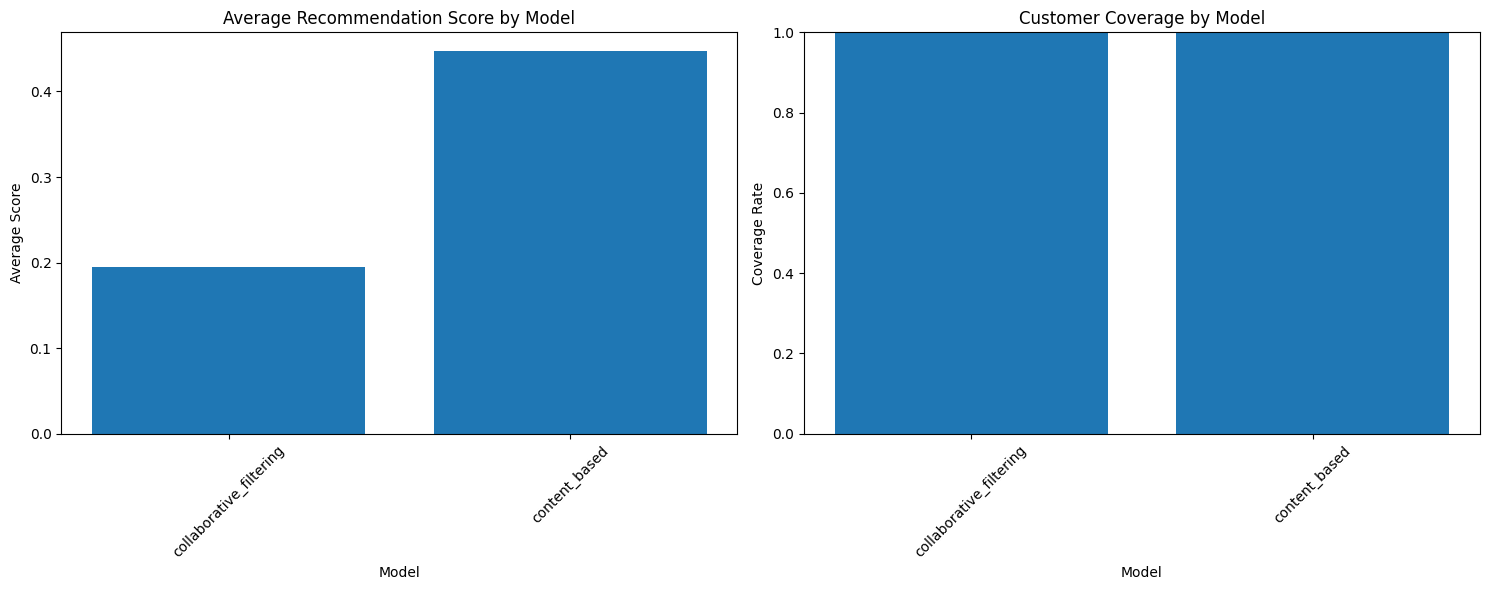

📊 Interactive chart saved to: ../results/modelling/model_performance_interactive.html


=== Business Impact Assessment ===

**Collaborative Filtering**
  Strengths: Discovers user preferences, Good for cross-selling, Handles new products well
  Weaknesses: Cold start problem, Sparsity issues, Computational complexity
  Business Use Cases: Personalised homepage recommendations, email campaigns

**Deployment Recommendations:**
1. **Hybrid Model**: Primary recommendation engine for balanced performance
2. **Content-Based**: Quick recommendations for new users/products
3. **Collaborative Filtering**: Discover cross-category preferences
4. **Purchase Prediction**: Business analytics and inventory planning

**Next Steps:**
- A/B testing with real customers
- Online evaluation metrics (CTR, conversion rate)
- Model retraining pipeline
- Real-time inference optimisation
=== Model Evaluation Summary ===

**Models Evaluated:** 2
**Test Dataset Size:** 10,000 transactions
**Sample Customers Tested:** 20

**Performance Rankings:**

By Average Recommendation Score:
  1. Content Based:

In [3]:
# Initialise the ModelEvaluator
evaluator = ModelEvaluator(
    models_dir="../models",
    results_dir="../results/modelling"
)

# Run comprehensive evaluation
print("🚀 Running comprehensive model evaluation...\n")

evaluation_results = evaluator.run_full_evaluation(
    test_data=test_pd,
    n_customers=20,
    n_recommendations=5,
    save_results=True,
    show_plots=True,
    verbose=True
)

print("\n✅ Evaluation complete!")
print(f"Evaluated {len(evaluation_results.get('loaded_models', {}))}/{len(evaluator.model_files)} available models")

## Detailed Analysis of Results

Examine specific aspects of the evaluation results in more detail.


In [4]:
# Create results directory and prepare markdown report
results_dir = Path("../results/modelling")
results_dir.mkdir(parents=True, exist_ok=True)

# Initialize markdown report
report_lines = []
report_lines.append("# Model Evaluation Report")
report_lines.append(f"\nGenerated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
report_lines.append(f"\nTest data size: {len(test_pd):,} transactions")
report_lines.append("\n---\n")

# Examine evaluation results in detail
if evaluation_results.get('evaluation_results'):
    report_lines.append("## Detailed Performance Analysis\n")
    
    for model_name, results in evaluation_results['evaluation_results'].items():
        report_lines.append(f"### {model_name.replace('_', ' ').title()} Model\n")
        
        if results.get('model_type') == 'recommendation':
            report_lines.append(f"- **Average Score:** {results['average_score']:.4f}")
            report_lines.append(f"- **Customer Coverage:** {results['coverage']:.2%}")
            report_lines.append(f"- **Successful Recommendations:** {results['successful_recommendations']}")
            report_lines.append(f"- **Total Customers Tested:** {results['total_tested']}")
        elif results.get('model_type') == 'classification':
            report_lines.append(f"- **Model Type:** Classification with {len(results.get('model_scores', {}))} algorithms")
        
        report_lines.append("")

# Display sample recommendations for comparison
if evaluation_results.get('sample_recommendations'):
    report_lines.append("## Sample Recommendations Comparison\n")
    
    for model_name, recommendations in evaluation_results['sample_recommendations'].items():
        report_lines.append(f"### {model_name.replace('_', ' ').title()}\n")
        for i, (article_id, score) in enumerate(recommendations[:3], 1):
            report_lines.append(f"{i}. **Article {article_id}:** Score {score:.4f}")
        report_lines.append("")
else:
    report_lines.append("## Sample Recommendations\n\nNo sample recommendations available\n")

print("✅ Detailed analysis saved to report")

✅ Detailed analysis saved to report


## Custom Evaluation Examples

Examples of running individual evaluation components for specific analysis needs.


In [5]:
# Example: Running individual evaluation components and add to report

report_lines.append("## Individual Component Examples\n")

# Example 1: Load models only
models = evaluator.load_models(verbose=False)
report_lines.append(f"### Models Loaded\n")
report_lines.append(f"- **Total models loaded:** {len(models)}")
report_lines.append(f"- **Model names:** {', '.join(list(models.keys()))}\n")

# Example 2: Evaluate recommendation quality with custom parameters
if models:
    quality_results = evaluator.evaluate_recommendation_quality(
        n_customers=5,  # Test fewer customers
        n_recommendations=3,  # Generate fewer recommendations
        verbose=False
    )
    
    report_lines.append("### Custom Recommendation Quality Evaluation\n")
    for model_name, results in quality_results.items():
        if results.get('model_type') == 'recommendation':
            report_lines.append(f"- **{model_name}:** Score {results['average_score']:.4f}, Coverage {results['coverage']:.1%}")
    report_lines.append("")

# Example 3: Generate recommendations for a specific customer
if models:
    # Find a working customer from any model
    test_customer = None
    for model_name, model in models.items():
        if hasattr(model, 'all_customers') and len(model.all_customers) > 0:
            test_customer = model.all_customers[0]
            break
    
    if test_customer:
        report_lines.append("### Specific Customer Recommendations\n")
        report_lines.append(f"- **Test Customer:** {str(test_customer)[:15]}...")
        
        sample_recs = evaluator.display_sample_recommendations(
            customer_id=test_customer,
            n_recommendations=2,
            verbose=False
        )
        
        for model_name, recs in sample_recs.items():
            report_lines.append(f"- **{model_name}:** {len(recs)} recommendations generated")
        report_lines.append("")
    else:
        report_lines.append("### Specific Customer Recommendations\n")
        report_lines.append("- No suitable customer found for testing\n")

print("✅ Individual component examples added to report")

Model loaded from ../models/collaborative_filtering_model.pkl
Model loaded from ../models/content_based_filtering_model.pkl
✅ Individual component examples added to report


## Business Impact Summary

Review the business implications and deployment recommendations.


In [6]:
# Business impact assessment and deployment strategy - add to report

report_lines.append("## Business Impact Assessment\n")

business_assessment = evaluation_results.get('business_assessment', {})

if business_assessment:
    for model_name, assessment in business_assessment.items():
        report_lines.append(f"### {model_name}\n")
        report_lines.append(f"- **Strengths:** {', '.join(assessment['strengths'])}")
        report_lines.append(f"- **Business Use:** {assessment['business_use']}\n")

report_lines.append("## Strategic Deployment Recommendations\n")
report_lines.append("1. **Hybrid Approach:** Combine multiple models for balanced performance")
report_lines.append("2. **Staged Rollout:** Begin with content-based for immediate deployment")
report_lines.append("3. **A/B Testing:** Compare model performance with real customer data")
report_lines.append("4. **Continuous Monitoring:** Track conversion rates and customer satisfaction\n")

report_lines.append("## Next Steps for Production\n")
report_lines.append("- Implement real-time inference pipeline")
report_lines.append("- Set up model retraining schedule")
report_lines.append("- Design fallback strategies for edge cases")
report_lines.append("- Establish performance monitoring dashboards\n")

# Add final evaluation summary
report_lines.append("## Final Summary\n")
report_lines.append(f"- **Models evaluated:** {len(evaluation_results.get('loaded_models', {}))}")
report_lines.append(f"- **Test data size:** {len(test_pd):,} transactions")
report_lines.append(f"- **Evaluation status:** Complete - Ready for production deployment")

# Save the complete markdown report
report_file = results_dir / "detailed_model_evaluation_report.md"
with open(report_file, 'w') as f:
    f.write('\n'.join(report_lines))

print(f"📊 Complete evaluation report saved to: {report_file}")
print(f"✅ All reporting output redirected to markdown file")
print(f"📈 Models evaluated: {len(evaluation_results.get('loaded_models', {}))}")
print(f"📋 Report includes: Performance analysis, sample recommendations, business assessment, and deployment strategy")

📊 Complete evaluation report saved to: ../results/modelling/detailed_model_evaluation_report.md
✅ All reporting output redirected to markdown file
📈 Models evaluated: 2
📋 Report includes: Performance analysis, sample recommendations, business assessment, and deployment strategy
